In [4]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests
import folium 
from sklearn.cluster import KMeans

#Reading Dataset
data = pd.read_csv('/content/data.csv',usecols=['Borough','Neighborhoods','Latitude','Longitude','Population','City','AverageIncome'])
data.head()

,Borough,Neighborhoods,Latitude,Longitude,Population,City,AverageIncome
0,Central,Cantonment area,12.972442,77.580643,866377,Bangalore,18944.099790
1,Central,Domlur,12.960992,77.638726,743186,Bangalore,56837.022200
2,Central,Indiranagar,12.971891,77.641151,474289,Bangalore,41991.817440
3,Central,Jeevanbheemanagar,12.962900,77.659500,527874,Bangalore,6667.447632
4,Central,Malleswaram,13.003100,77.564300,893629,Bangalore,53270.063890


In [5]:
b_population = data[['Borough', 'Neighborhoods', 'Population']]
b_income = data[['Borough', 'Neighborhoods', 'AverageIncome']]

# Save b_income dataframe to CSV file
b_income.to_csv('income_dataset.csv', index=False)

# Calculate mean latitude and longitude values
b_latitude, b_longitude = data[['Latitude', 'Longitude']].mean()

In [6]:
unique_boroughs = data['Borough'].unique()
colors = {borough: '#{:06x}'.format(np.random.randint(0, 0xFFFFFF))
          for borough in unique_boroughs}
colors

{'Central': '#59e6b0',
 'Eastern': '#e65804',
 'NorthEastern': '#445667',
 'Northern': '#1aa265',
 'SouthEastern': '#9e357c',
 'Southern': '#155f65',
 'SouthernSuburbs': '#9021b9',
 'Western': '#8581db'}

In [7]:
# Create map centered on mean latitude and longitude
map = folium.Map(location=[b_latitude, b_longitude], zoom_start=12, control_scale=True)

# Iterate over the rows of the dataframe and add markers to the map
for row in data.itertuples():
    label_text = f"{row.Borough} - {row.Neighborhoods}"
    label = folium.Popup(label_text, parse_html=True)
    folium.CircleMarker(
        [row.Latitude, row.Longitude],
        tooltip=label_text,
        radius=4,
        popup=label,
        color=colors[row.Borough],
        fill=True,
        fill_color=colors[row.Borough],
        fill_opacity=0.7
    ).add_to(map)

map

In [8]:
CLIENT_ID = 'ZK40VO3EPO1ZY5C04PNYSMQH2ZFZ3U1TPL0QME3WEY553DMH'
CLIENT_SECRET = 'RQBRNE2T3OTMYY4BBJ3YWLS0P2FK413O22MQV1QHBHAD04WG'
VERSION = '20180606'
LIMIT = 300

def getNearbyVenues(names, boro, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, boro, lat, lng in zip(names, boro, latitudes, longitudes):
        print("Fetching venues for : ",name)            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            boro,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Borough',
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

bangalore_venues = getNearbyVenues(names=data['Neighborhoods'],latitudes=data['Latitude'],longitudes=data['Longitude'],boro=data['Borough'])

# get the top 5 venue categories
top_categories = bangalore_venues.groupby('Venue Category').count()['Neighborhood'].sort_values(ascending=False).head(5)

Fetching venues for :  Cantonment area
Fetching venues for :  Domlur
Fetching venues for :  Indiranagar
Fetching venues for :  Jeevanbheemanagar
Fetching venues for :  Malleswaram
Fetching venues for :  Pete area
Fetching venues for :  Rajajinagar
Fetching venues for :  Sadashivanagar
Fetching venues for :  Seshadripuram
Fetching venues for :  Shivajinagar
Fetching venues for :  Ulsoor
Fetching venues for :  Vasanth Nagar
Fetching venues for :  Bellandur
Fetching venues for :  CV Raman Nagar
Fetching venues for :  Hoodi
Fetching venues for :  Krishnarajapuram
Fetching venues for :  Mahadevapura
Fetching venues for :  Marathahalli
Fetching venues for :  Varthur
Fetching venues for :  Whitefield
Fetching venues for :  Banaswadi
Fetching venues for :  HBR Layout
Fetching venues for :  Horamavu
Fetching venues for :  Kammanahalli
Fetching venues for :  Lingarajapuram
Fetching venues for :  Ramamurthy Nagar
Fetching venues for :  Hebbal
Fetching venues for :  Jalahalli
Fetching venues for :

<Axes: xlabel='Neighborhood', ylabel='NumberOfVenues'>

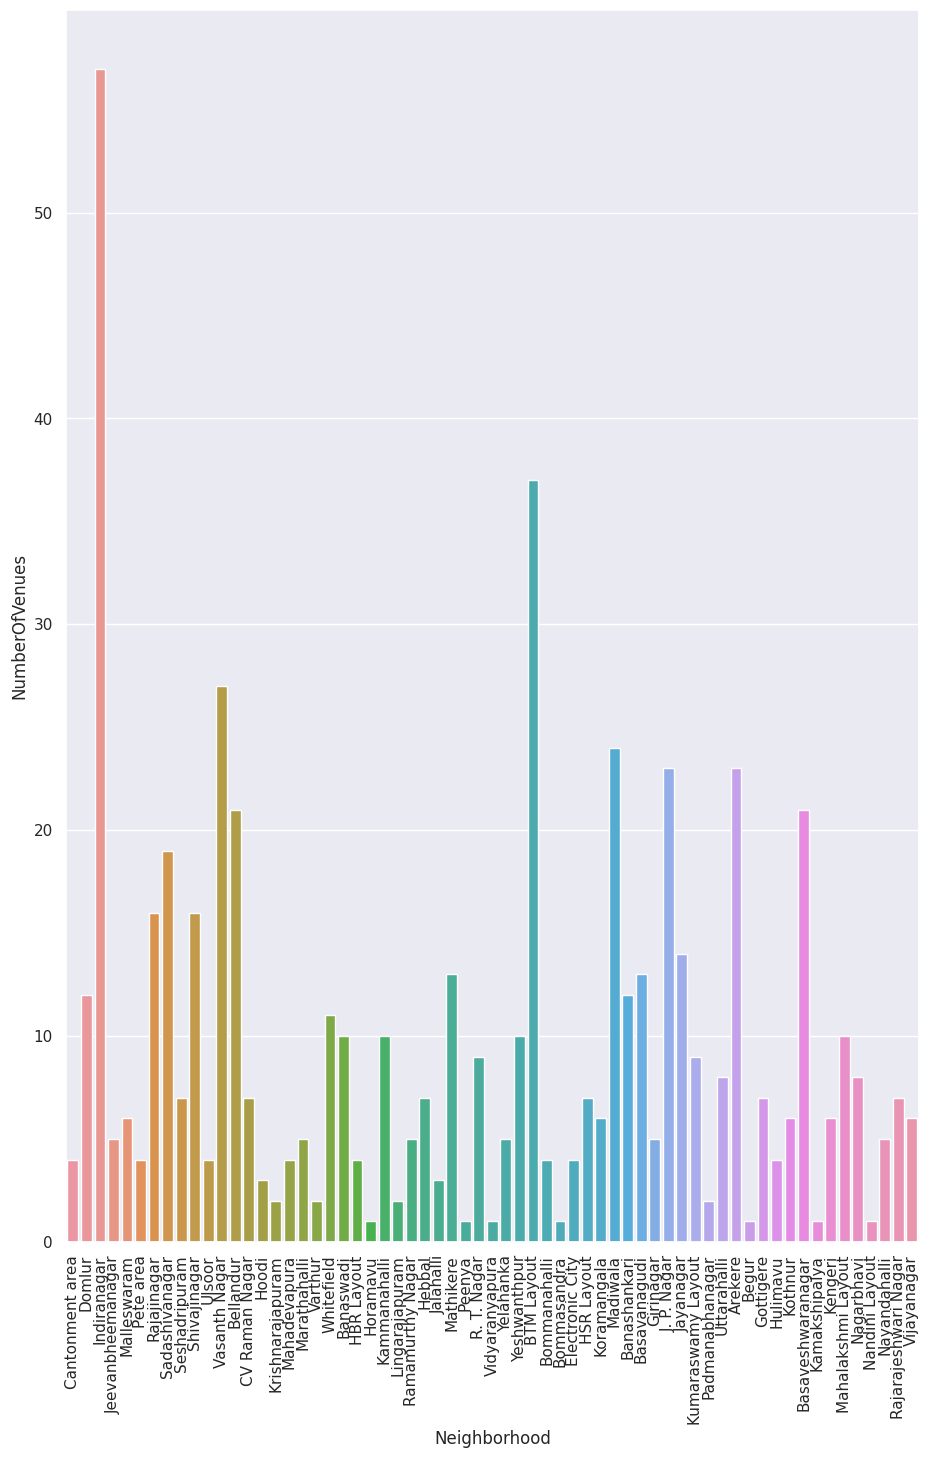

In [9]:
#venues per neighborhood
# Define function to plot individual venue counts for each neighborhood
def plot_individual_venue_counts(df):
    # Group by borough and neighborhood and count the number of venues
    venue_count = (df.groupby(['Borough', 'Neighborhood'])
                     .size()
                     .reset_index(name='NumberOfVenues'))
    
    # Create bar plot
    sns.set(rc={'figure.figsize': (11, 16)}) # Set plot size
    plot = sns.barplot(x='Neighborhood', y='NumberOfVenues', data=venue_count)
    plot.set_xticklabels(venue_count['Neighborhood'], rotation=90)
    
    return plot

# Call function with your dataframe
plot_individual_venue_counts(bangalore_venues)

In [10]:
# Get all venues for 'Whitefield' neighborhood
whitefield_venues = bangalore_venues[bangalore_venues['Neighborhood'] == 'Whitefield']

# Create one-hot encoding of venue categories
bangalore_venues_onehot = pd.get_dummies(bangalore_venues[['Venue Category']])
bangalore_venues_onehot['Neighborhood'] = bangalore_venues['Neighborhood']

# Group venues by neighborhood and calculate the mean of each category
bangalore_venues_grouped = bangalore_venues_onehot.groupby('Neighborhood').mean().reset_index()

# Define function to return most common venues
def return_most_common_venues(row, number_of_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:number_of_top_venues]

# Define number of top venues to consider
number_of_top_venues = 10

# Create columns for top venues
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for ind in np.arange(number_of_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create new dataframe to store top venues
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bangalore_venues_grouped['Neighborhood']

# Populate dataframe with most common venues for each neighborhood
for ind in np.arange(bangalore_venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bangalore_venues_grouped.iloc[ind, :], number_of_top_venues)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

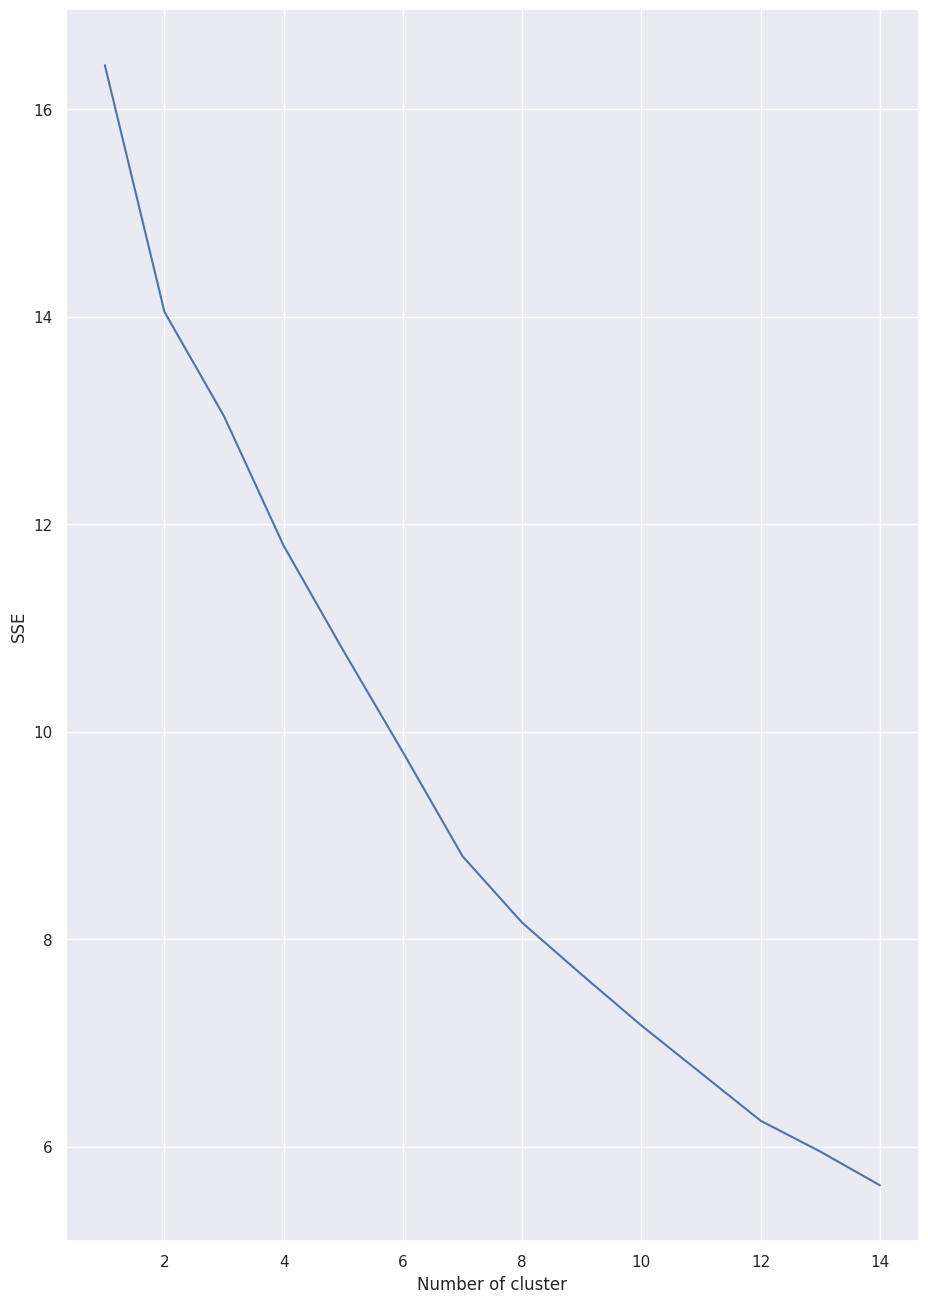

In [11]:
# Create an empty dictionary to store the SSE values for different numbers of clusters
value_sse = {}
for k in range(1,15):
    kmeans = KMeans(n_clusters=k,random_state=0)
    kmeans.fit(bangalore_venues_grouped.drop('Neighborhood',axis=1))
    bangalore_venues_grouped['Cluster'] = kmeans.labels_
    value_sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(value_sse.keys()), list(value_sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [12]:
# Set the number of clusters
num_clusters = 7

# Create a KMeans model with the specified number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)

# Fit the model on the data and assign cluster labels to each neighborhood
kmeans.fit(bangalore_venues_grouped.drop('Neighborhood', axis=1))
bangalore_venues_grouped['Cluster'] = kmeans.labels_

# Merge the clustered data with the sorted venue data on the 'Neighborhood' column
neighborhoods_venues_sorted = neighborhoods_venues_sorted.merge(bangalore_venues_grouped, on='Neighborhood')

# Merge the clustered data with the original venue data on the 'Neighborhood' column
neighborhoods_venues_sorted = neighborhoods_venues_sorted.merge(bangalore_venues, on='Neighborhood')

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [13]:
#Normalize population and income
b_population['Normalized_population'] = b_population['Population']/b_population['Population'].max(axis=0)
b_income['Normalized_income'] = b_income['AverageIncome']/b_income['AverageIncome'].max(axis=0)
bangalore_veg = bangalore_venues_onehot.groupby(['Neighborhood']).sum().reset_index()
bangalore_veg = bangalore_veg[['Neighborhood','Venue Category_Vegetarian / Vegan Restaurant']]
bangalore_veg.rename(columns={'Venue Category_Vegetarian / Vegan Restaurant':'NumberOfVegRestaurants'},inplace=True)
bangalore_veg['NumberOfNonVeganrestaurants'] = 1-(bangalore_veg['NumberOfVegRestaurants']/bangalore_veg['NumberOfVegRestaurants'].max(axis=0))
bangalore_veg.rename(columns={'Neighborhood':'Neighborhoods'},inplace=True)

<ipython-input-13-8fec9a45e7a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b_population['Normalized_population'] = b_population['Population']/b_population['Population'].max(axis=0)
<ipython-input-13-8fec9a45e7a3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b_income['Normalized_income'] = b_income['AverageIncome']/b_income['AverageIncome'].max(axis=0)


In [14]:
# Building a target neighborhood
target_neighborhood = 'Whitefield'
target_cluster = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Neighborhood'] == target_neighborhood, 'Cluster'].values[0]

possible_neighborhoods = neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster'] == target_cluster].copy()
possible_neighborhoods.rename(columns={'Neighborhood': 'Neighborhoods'}, inplace=True)

n_possible_neighborhoods = possible_neighborhoods.shape[0]
print(f"There are {n_possible_neighborhoods} neighborhoods which have similar characteristics to {target_neighborhood}.")

There are 212 neighborhoods which have similar characteristics to Whitefield.


In [15]:
#Building a target neighborhood 
target_cluster_dataframe = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Neighborhood']=='Whitefield']
target_cluster = target_cluster_dataframe.iloc[0].at['Cluster']
possible_neighborhoods = neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster']==target_cluster]
possible_neighborhoods.rename(columns={'Neighborhood':'Neighborhoods'},inplace=True)
possible_neighborhoods = possible_neighborhoods.merge(b_population[['Neighborhoods','Population','Normalized_population']],on='Neighborhoods')
possible_neighborhoods = possible_neighborhoods.merge(b_income[['Neighborhoods','AverageIncome','Normalized_income']],on='Neighborhoods')
possible_neighborhoods = possible_neighborhoods.merge(bangalore_veg[['Neighborhoods','NumberOfVegRestaurants','NumberOfNonVeganrestaurants']],on='Neighborhoods')

<ipython-input-15-50b1ae7eca4b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  possible_neighborhoods.rename(columns={'Neighborhood':'Neighborhoods'},inplace=True)


In [16]:
possible_neighborhoods['Ranking'] = possible_neighborhoods['Normalized_population'] * 0.5 + possible_neighborhoods['Normalized_income'] * 0.35 + possible_neighborhoods['NumberOfNonVeganrestaurants'] * 0.1
recommended_neighborhoods = possible_neighborhoods.sort_values(by='Ranking',ascending=False)
recommended_neighborhoods.reset_index(inplace=True, drop=True)

In [17]:
top3 = recommended_neighborhoods.groupby(['Neighborhoods','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue'])['Ranking'].unique()
top3_data = pd.DataFrame(top3).reset_index()
top3_data.head(3)

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Ranking
0,Banashankari,Venue Category_Café,Venue Category_Clothing Store,Venue Category_Pizza Place,[0.8234029969298623]
1,Basaveshwaranagar,Venue Category_Fast Food Restaurant,Venue Category_Indian Restaurant,Venue Category_Ice Cream Shop,[0.6426377807651089]
2,Electronic City,Venue Category_Furniture / Home Store,Venue Category_Bus Stop,Venue Category_Outlet Store,[0.5423513638776338]
